In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [23]:
def readMatrix_NB(file):
    fd = open(file, 'r')
    hdr = fd.readline()
    rows, cols = [int(s) for s in fd.readline().strip().split()]
    tokens = fd.readline().strip().split()
    matrix = np.zeros((rows, cols))
    Y = []
    for i, line in enumerate(fd):
        nums = [int(x) for x in line.strip().split()]
        Y.append(nums[0])
        kv = np.array(nums[1:])
        k = np.cumsum(kv[:-1:2])
        v = kv[1::2]
        matrix[i, k] = v
    return matrix, tokens, np.array(Y)

In [24]:
def readMatrix_SVM(file):
    fd = open(file, 'r')
    hdr = fd.readline()
    rows, cols = [int(s) for s in fd.readline().strip().split()]
    tokens = fd.readline().strip().split()
    matrix = np.zeros((rows, cols))
    Y = []
    for i, line in enumerate(fd):
        nums = [int(x) for x in line.strip().split()]
        Y.append(nums[0])
        kv = np.array(nums[1:])
        k = np.cumsum(kv[:-1:2])
        v = kv[1::2]
        matrix[i, k] = v
    category = (np.array(Y) * 2) - 1
    return matrix, tokens, category

In [3]:
def nb_train(matrix, category):
    state = {}
    N = matrix.shape[1]
    ###################
    phi_y = 0
    phi_k_y1 = np.zeros((N,1))
    phi_k_y0 = np.zeros((N,1))
    denom_phi_k_y1 = 0
    denom_phi_k_y0 = 0
    for i in range(matrix.shape[0]):
        if (category[i] == 1):
            phi_y += 1
            denom_phi_k_y1 += np.sum(matrix[i])
            for j in range(N):
                phi_k_y1[j] += matrix[i,j]
        elif (category[i] == 0):
            denom_phi_k_y0 += np.sum(matrix[i])
            for j in range(N):
                phi_k_y0[j] += matrix[i,j]
    phi_y /= matrix.shape[0]
    phi_k_y0 = (1 + phi_k_y0) / (denom_phi_k_y0 + N)
    phi_k_y1 = (1 + phi_k_y1) / (denom_phi_k_y1 + N)
    state = (phi_k_y0, phi_k_y1, phi_y)
    ###################
    return state

In [4]:
def nb_test(matrix, state):
    output = np.zeros(matrix.shape[0])
    ###################
    for i in range(matrix.shape[0]):
        log_p_x_y1 = 0
        log_p_x_y0 = 0
        for j in range(matrix.shape[1]):
            log_p_x_y0 += matrix[i,j] * np.log(state[0][j])
            log_p_x_y1 += matrix[i,j] * np.log(state[1][j])
        if (log_p_x_y1 + np.log(state[2]) > log_p_x_y0 + np.log(1-state[2])):
            output[i] = 1
    ###################
    return output

In [20]:
tau = 8.

In [5]:
def svm_train(matrix, category):
    state = {}
    M, N = matrix.shape
    #####################
    Y = category
    matrix = 1. * (matrix > 0)
    squared = np.sum(matrix * matrix, axis=1)
    gram = matrix.dot(matrix.T)
    K = np.exp(-(squared.reshape((1, -1)) + squared.reshape((-1, 1)) - 2 * gram) / (2 * (tau ** 2)) )

    alpha = np.zeros(M)
    alpha_avg = np.zeros(M)
    L = 1. / (64 * M)
    outer_loops = 40

    alpha_avg
    for ii in range(outer_loops * M):
        i = int(np.random.rand() * M)
        margin = Y[i] * np.dot(K[i, :], alpha)
        grad = M * L * K[:, i] * alpha[i]
        if (margin < 1):
            grad -=  Y[i] * K[:, i]
        alpha -=  grad / np.sqrt(ii + 1)
        alpha_avg += alpha

    alpha_avg /= (ii + 1) * M

    state['alpha'] = alpha
    state['alpha_avg'] = alpha_avg
    state['Xtrain'] = matrix
    state['Sqtrain'] = squared
    ####################
    return state

In [6]:
def svm_test(matrix, state):
    M, N = matrix.shape
    output = np.zeros(M)
    ###################
    Xtrain = state['Xtrain']
    Sqtrain = state['Sqtrain']
    matrix = 1. * (matrix > 0)
    squared = np.sum(matrix * matrix, axis=1)
    gram = matrix.dot(Xtrain.T)
    K = np.exp(-(squared.reshape((-1, 1)) + Sqtrain.reshape((1, -1)) - 2 * gram) / (2 * (tau ** 2)))
    alpha_avg = state['alpha_avg']
    preds = K.dot(alpha_avg)
    output = np.sign(preds)
    ###################
    return output

In [10]:
def evaluate(output, label, algo, printError = True):
    error = (output != label).sum() * 1. / len(output)
    if (printError) and (algo == 'NB'):
        print('Naive Bayes error: %1.4f' % error)
    elif (printError) and (algo == 'SVM'):
        print('SVM error: %1.4f' % error)
    return error

In [11]:
def five_most_indicative_tokens(tokenlist, state):
    indicator = np.argsort((np.log(state[1]) - np.log(state[0])).flatten())
    N = indicator.shape[0]
    print("Five most indicative tokens by Naive Bayes (descending order): ", 
          tokenlist[indicator[N-1]], ' ',
          tokenlist[indicator[N-2]], ' ',
          tokenlist[indicator[N-3]], ' ',
          tokenlist[indicator[N-4]], ' ',
          tokenlist[indicator[N-5]])
    return

In [29]:
def main():
    trainMatrix_NB, tokenlist_NB, trainCategory_NB = readMatrix_NB('spam_data/MATRIX.TRAIN')
    testMatrix_NB, tokenlist_NB, testCategory_NB = readMatrix_NB('spam_data/MATRIX.TEST')
    
    trainMatrix_SVM, tokenlist_SVM, trainCategory_SVM = readMatrix_SVM('spam_data/MATRIX.TRAIN')
    testMatrix_SVM, tokenlist_SVM, testCategory_SVM = readMatrix_SVM('spam_data/MATRIX.TEST')

    state_NB = nb_train(trainMatrix_NB, trainCategory_NB)
    output_NB = nb_test(testMatrix_NB, state_NB)
    evaluate(output_NB, testCategory_NB, "NB")
    
    five_most_indicative_tokens(tokenlist_NB, state_NB)
    
    state_SVM = svm_train(trainMatrix_SVM, trainCategory_SVM)
    output_SVM = svm_test(testMatrix_SVM, state_SVM)
    evaluate(output_SVM, testCategory_SVM, "SVM")
    
    idx = (50, 100, 200, 400, 800, 1400)
    error_nb = []
    error_svm = []
    for i in idx:
        trainMatrix_NB_i, tokenlist__NB_i, trainCategory_NB_i = readMatrix_NB('spam_data/MATRIX.TRAIN.' + str(i))
        trainMatrix_SVM_i, tokenlist_SVM_i, trainCategory_SVM_i = readMatrix_SVM('spam_data/MATRIX.TRAIN.' + str(i))
        nb_state_i = nb_train(trainMatrix_NB_i, trainCategory_NB_i)
        nb_output_i = nb_test(testMatrix_NB, nb_state_i)
        svm_state_i = svm_train(trainMatrix_SVM_i, trainCategory_SVM_i)
        svm_output_i = svm_test(testMatrix_SVM, svm_state_i)
        error_nb.append(evaluate(nb_output_i, testCategory_NB, "NB", False))
        error_svm.append(evaluate(svm_output_i, testCategory_SVM, "SVM", False))
    
    plt.subplot(2,1,1)
    plt.xlabel("Training set size")
    plt.ylabel("NB Error")
    plt.plot(idx, error_nb)
    
    plt.subplot(2,1,2)
    plt.xlabel("Training set size")
    plt.ylabel("SVM Error")
    plt.plot(idx, error_svm)
    
    plt.show()
    
    # SVM generalization error quickly reduces at 200 training examples and then plateau, 
    # while Naive Bayes error only tends to plateau at 400 training examples.
    # SVM is much more accurate than Naive Bayes with significantly lower training time.
    
    return

Naive Bayes error: 0.0163
Five most indicative tokens by Naive Bayes (descending order):  httpaddr   spam   unsubscrib   ebai   valet
SVM error: 0.0013


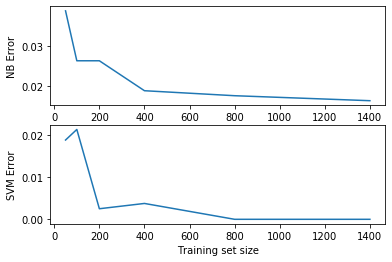

In [30]:
if __name__ == '__main__':
    main()